In [1]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = "D:/data/SiPM/waveforms/20240501/"
filename_list = ["Am241_x0_y0_*.pkl",] # "Am241_vb_28V_coated_scint_x0_y0.pkl"] #,"Am241_vb_29V_*.pkl",]
save_str = ["Am241",]
ov_list = [29,] #29]
data_time = [10,] ## acquisition time in minutes

In [33]:
ovs_dict = {}
for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(wf['time'])	
                
                ## subtract baseline
                baseline = 2048 

                for k, ch in enumerate(range(16,-1,-2)):
                    sum_waveform += (wf[ch] - baseline)

                data_dict[wfidx] = sum_waveform   
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = wf['time']*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 10230 waveforms for 10 files: Am241_x0_y0_*.pkl


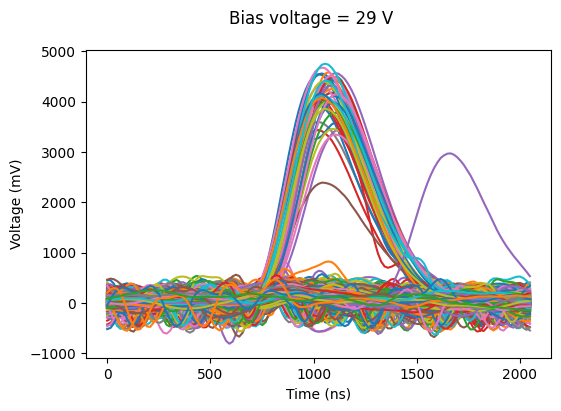

In [34]:
make_plot = True
max_figs = 1000

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(6,4))
        #plt.subplot(1,2,1)
        #for j in range(nwaveforms):
        #    if(j%downsamp != 0): continue
        #    plt.plot(data_dict['time'], data_dict[j][0])
        #    plt.xlabel('Time (ns)')
        #    plt.ylabel('Voltage (mV)')

        #plt.subplot(1,2,2)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.suptitle("Bias voltage = %s V"%str(ov))



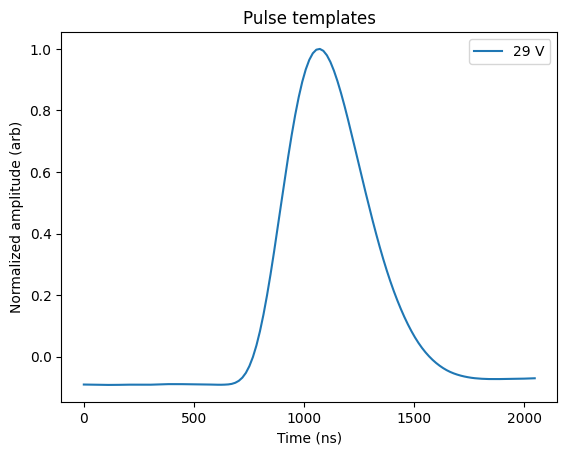

In [35]:
template_dict = {}

plt.figure()
for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template = np.zeros_like(data_dict['time'])

    nwfm = 0
    for j in range(nwaveforms):

        cdat = data_dict[j]

        ## throw out bad traces
        if np.max(cdat) < 1000:
            continue

        template += cdat
        nwfm += 1

    template /= nwfm
    template -= np.median(template[:100])
    template /= np.max(template)

    plt.plot(data_dict['time'], template, label="%s V"%str(ov))
    plt.xlabel('Time (ns)')
    plt.ylabel('Normalized amplitude (arb)')

    template_dict[ov] = template

plt.title("Pulse templates")
plt.legend()
plt.show()

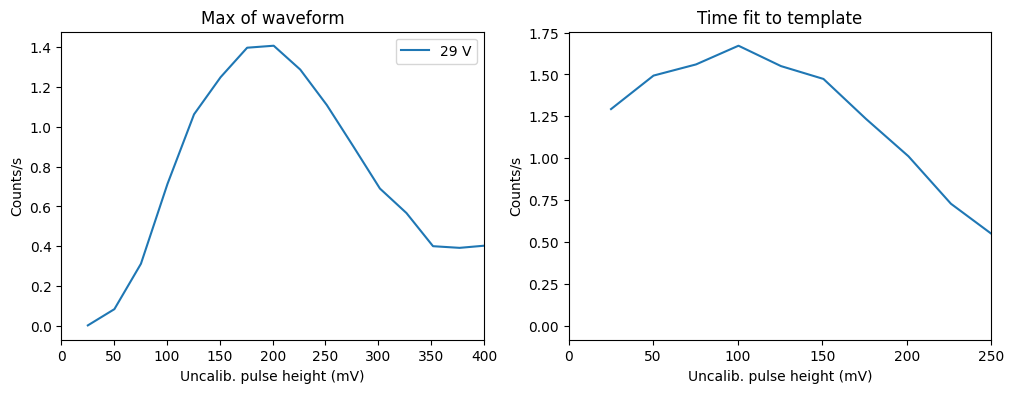

In [43]:
plt.figure(figsize=(12,4))
remake_files = True
for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [800, 1300]

        data_dict = ovs_dict[ov]['data_dict']

        mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

        recon_amps = []        
        for k in data_dict.keys():
            if k == 'time': continue

            cdat = data_dict[k]
            
            ## baseline subtract
            cdat -= np.median(cdat[:50])

            fit = np.sum( cdat*template_dict[ov] ) / np.sum(template_dict[ov]**2)

            midx = np.argmax(np.abs(cdat[mpts]))
            max_val = cdat[mpts][midx]
            recon_amps.append( [max_val, fit] )

        recon_amps = np.array(recon_amps)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps=recon_amps,nwaveforms=nwaveforms)
    else:
        data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
        recon_amps = data['recon_amps']
        nwaveforms = data['nwaveforms']
    

    bins = np.linspace(0,5000,200)
    bc = bins[:-1] + np.diff(bins)

    norm = data_time[oidx]*60

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    if('bkg' in str(ov)): 
        continue

    plt.subplot(1,2,1)
    plt.plot(bc, h_max/norm, label="%s V"%str(ov))
    plt.xlim(0,5000)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.title("Max of waveform")

    plt.subplot(1,2,2)
    plt.plot(bc, h_fit/norm)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.xlim(0,5000)
    plt.title("Time fit to template")

plt.subplot(1,2,1)
plt.legend()
plt.show()

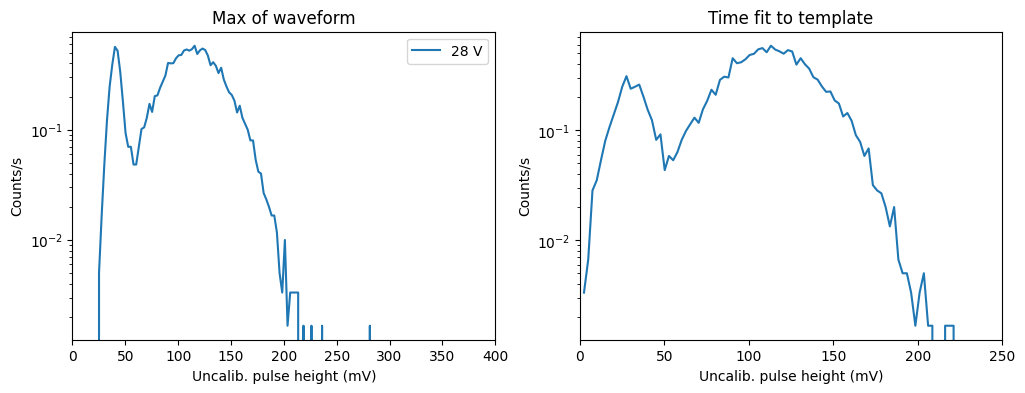

In [28]:
plt.figure(figsize=(12,4))
spec_list = []
for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps = data['recon_amps']
    nwaveforms = data['nwaveforms']
    

    bins = np.linspace(0,500,200)
    bc = bins[:-1] + np.diff(bins)

    norm = data_time[oidx]*60

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    if('28' not in str(ov)): 
        continue

    spec_list.append(h_max)

    plt.subplot(1,2,1)
    plt.semilogy(bc, h_max/norm, label="%s V"%str(ov))
    plt.xlim(0,400)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.title("Max of waveform")

    plt.subplot(1,2,2)
    plt.semilogy(bc, h_fit/norm)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.xlim(0,250)
    plt.title("Time fit to template")

plt.subplot(1,2,1)
plt.legend()
plt.show()

In [29]:
plt.figure()
norm2 = np.max(spec_list[1])/np.max(spec_list[0])

diff_spec = spec_list[0]*norm2 - spec_list[1]

rate = np.trapz(diff_spec/norm)
print("Total counts/s :", rate)

plt.semilogy(bc, diff_spec/norm, 'k', label="Total rate = %.1f Hz"%rate)
plt.xlim(0,400)



plt.xlabel("Uncalib. pulse height (mV)")
plt.ylabel("Counts/s")
plt.title("Difference spectrum, Max of waveform")
plt.legend()
plt.show()

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>